[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - The Leaky Integrate and Fire Neuron
## Tutorial 2
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_2_lif_neuron.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>


# Introduction

이 튜토리얼에서 여러분은 다음을 배우게 됩니다:

* 누설 적분 발화(Leaky Integrate-and-Fire, LIF) 뉴런 모델의 기본 원리 학습
* snnTorch를 사용하여 1차 LIF 뉴런 구현

다음 셀을 클릭한 후 `Shift+Enter`를 눌러 snnTorch의 최신 PyPi 배포판을 설치하세요.


In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.1 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [3]:
#@title Plotting Settings
def plot_mem(mem, title=False):
  if title:
    plt.title(title)
  plt.plot(mem)
  plt.xlabel("Time step")
  plt.ylabel("Membrane Potential")
  plt.xlim([0, 50])
  plt.ylim([0, 1])
  plt.show()

def plot_step_current_response(cur_in, mem_rec, vline1):
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title("Lapicque's Neuron Model With Step Input")

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()


def plot_current_pulse_response(cur_in, mem_rec, title, vline1=False, vline2=False, ylim_max1=False):

  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur_in, c="tab:orange")
  if not ylim_max1:
    ax[0].set_ylim([0, 0.2])
  else:
    ax[0].set_ylim([0, ylim_max1])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem_rec)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  if vline1:
    ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  if vline2:
    ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.xlabel("Time step")

  plt.show()

def compare_plots(cur1, cur2, cur3, mem1, mem2, mem3, vline1, vline2, vline3, vline4, title):
  # Generate Plots
  fig, ax = plt.subplots(2, figsize=(8,6),sharex=True)

  # Plot input current
  ax[0].plot(cur1)
  ax[0].plot(cur2)
  ax[0].plot(cur3)
  ax[0].set_ylim([0, 0.2])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem1)
  ax[1].plot(mem2)
  ax[1].plot(mem3)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")

  ax[1].axvline(x=vline1, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline2, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline3, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  ax[1].axvline(x=vline4, ymin=0, ymax=2.2, alpha = 0.25, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)

  plt.xlabel("Time step")

  plt.show()

def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, 0.4])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_spk_mem_spk(spk_in, mem, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  plt.yticks([])

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, 1])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()


def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0):
  # Generate Plots to Compare Reset Mechanisms
  fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4], 'wspace':0.05})

  # Reset by Subtraction: input spikes
  splt.raster(spk_in, ax[0][0], s=400, c="black", marker="|")
  ax[0][0].set_ylabel("Input Spikes")
  ax[0][0].set_title("Reset by Subtraction")
  ax[0][0].set_yticks([])

  # Reset by Subtraction: membrane potential
  ax[1][0].plot(mem_rec)
  ax[1][0].set_ylim([0, 0.7])
  ax[1][0].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1][0].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)

  # Reset by Subtraction: output spikes
  splt.raster(spk_rec, ax[2][0], s=400, c="black", marker="|")
  ax[2][0].set_yticks([])
  ax[2][0].set_xlabel("Time step")
  ax[2][0].set_ylabel("Output Spikes")

  # Reset to Zero: input spikes
  splt.raster(spk_in, ax[0][1], s=400, c="black", marker="|")
  ax[0][1].set_title("Reset to Zero")
  ax[0][1].set_yticks([])

  # Reset to Zero: membrane potential
  ax[1][1].plot(mem_rec0)
  ax[1][1].set_ylim([0, 0.7])
  ax[1][1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  ax[1][1].set_yticks([])
  ax[2][1].set_xlabel("Time step")

  # Reset to Zero: output spikes
  splt.raster(spk_rec0, ax[2][1], s=400, c="black", marker="|")
  ax[2][1].set_yticks([])

  plt.show()

# 1. The Spectrum of Neuron Models

뉴런 모델에는 매우 다양한 종류가 있으며, 생물물리학적으로 정밀한 모델(예: Hodgkin-Huxley 모델)부터 현대 딥러닝의 모든 영역에 퍼져 있는 매우 단순한 인공 뉴런까지 존재합니다.

**Hodgkin-Huxley Neuron Models** − 생물물리학적 모델은 전기생리학적 결과를 매우 높은 정확도로 재현할 수 있지만, 복잡성이 높아 현재로서는 사용하기 어렵습니다.

**Artificial Neuron Model** − 반대쪽 끝에는 인공 뉴런이 있습니다. 입력값은 해당 가중치와 곱해진 뒤 활성화 함수로 전달됩니다. 이러한 단순화 덕분에 딥러닝 연구자들은 컴퓨터 비전, 자연어 처리, 그리고 많은 다른 머신러닝 분야에서 놀라운 성과를 이룰 수 있었습니다.

**Leaky Integrate-and-Fire Neuron Models** − 이 두 극단의 중간쯤에는 누설 적분 발화(Leaky Integrate-and-Fire, LIF) 뉴런 모델이 있습니다. LIF 뉴런은 인공 뉴런처럼 가중치가 곱해진 입력의 합을 계산합니다. 하지만 이를 곧바로 활성화 함수에 전달하는 대신, RC 회로처럼 시간이 지나면서 누설(leakage)을 고려하여 입력을 적분합니다. 적분된 값이 임계값을 초과하면 LIF 뉴런은 전압 스파이크를 방출합니다. LIF 뉴런은 출력 스파이크의 모양과 프로필을 추상화하며, 이를 단순히 하나의 이산 이벤트로 취급합니다. 결과적으로 스파이크 자체에 정보가 담기는 것이 아니라, 스파이크의 시점(timing)이나 빈도(frequency)에 정보가 담깁니다. 단순한 스파이킹 뉴런 모델은 신경 부호화(neural code), 기억, 네트워크 동역학, 그리고 최근에는 딥러닝에 이르기까지 많은 통찰을 제공해 왔습니다. LIF 뉴런은 생물학적 타당성과 실용성 사이의 균형점에 위치합니다.

<center>  
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">  
</center>  

LIF 모델의 다양한 버전은 각각 고유한 동역학과 사용 사례를 가지고 있습니다. snnTorch는 현재 다음과 같은 LIF 뉴런을 지원합니다:

* Lapicque의 RC 모델: `snntorch.Lapicque`
* 1차 모델: `snntorch.Leaky`
* 시냅스 전도 기반 뉴런 모델: `snntorch.Synaptic`
* 순환형 1차 모델: `snntorch.RLeaky`
* 순환형 시냅스 전도 기반 뉴런 모델: `snntorch.RSynaptic`
* 알파 뉴런 모델: `snntorch.Alpha`

또한 LIF가 아닌 여러 가지 스파이킹 뉴런도 사용할 수 있습니다. 이 튜토리얼에서는 위 모델 중 첫 번째를 다루며, 이는 [후속 튜토리얼](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 다른 모델로 확장하는 기반이 됩니다.


# 2. The Leaky Integrate-and-Fire Neuron Model

## 2.1 Spiking Neurons: Intuition

우리 뇌에서 하나의 뉴런은 약 1,000개에서 10,000개의 다른 뉴런과 연결될 수 있습니다. 하나의 뉴런이 스파이크를 발생시키면, 그 하위에 있는 뉴런들이 모두 그 영향을 받을 수 있습니다. 그렇다면 애초에 어떤 요인이 뉴런이 스파이크를 발생시키도록 결정할까요? 지난 한 세기 동안의 실험들은, 뉴런이 입력에서 *충분한* 자극을 받으면 흥분하여 스스로 스파이크를 발화할 수 있다는 것을 보여주었습니다.

그렇다면 이 자극은 어디에서 올까요? 다음과 같은 경우가 있습니다:

* 감각 말단에서 오는 경우
* 침습적 전극이 뉴런을 인위적으로 자극하는 경우
* 혹은 대부분의 경우, 다른 시냅스 전 뉴런(pre-synaptic neuron)에서 오는 경우

<center>  
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true' width="500">  
</center>  

스파이크는 매우 짧은 전기 활동의 폭발이기 때문에, 모든 입력 스파이크가 정확히 동시에 뉴런 본체에 도착하는 것은 거의 불가능합니다. 이는 입력 스파이크를 '지속'시키는, 일종의 지연과 같은 **시간적 동역학**이 존재함을 의미합니다.


## 2.2 The Passive Membrane

다른 모든 세포와 마찬가지로, 뉴런은 얇은 막에 둘러싸여 있습니다. 이 막은 지질 이중층(lipid bilayer)으로, 뉴런 내부의 전도성 염 용액을 세포 외부의 매질로부터 절연합니다. 전기적으로 보면, 절연체에 의해 분리된 두 개의 전도성 용액은 하나의 커패시터처럼 동작합니다.

이 막의 또 다른 기능은 세포 안팎으로 무엇이 들어오고 나가는지를 조절하는 것입니다(예: Na⁺ 이온). 막은 일반적으로 이온에 대해 불투과성이어서, 이온이 뉴런 본체에 들어오거나 나가는 것을 막습니다. 하지만 뉴런에 전류를 주입하면 열리도록 활성화되는 특정 채널이 막 안에 존재하며, 이러한 전하 이동은 전기적으로 저항기로 모델링됩니다.

<center>  
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_3_passivemembrane.png?raw=true' width="450">  
</center>  

다음 블록에서는 LIF 뉴런의 동작을 처음부터 수식으로 유도합니다. 수학적인 과정을 건너뛰고 싶다면 그냥 아래로 스크롤하셔도 됩니다. 유도 이후에는 LIF 뉴런의 동역학을 보다 실습 중심으로 이해하는 접근을 진행할 예정입니다.


---

**Optional: Derivation of LIF Neuron Model**

이제 전기적 자극이나 다른 뉴런으로부터 임의의 시간에 따라 변하는 전류 $I_{\rm in}(t)$가 뉴런에 주입된다고 하자. 회로의 전체 전류는 보존되므로,

$$
I_{\rm in}(t) = I_{R} + I_{C}
$$

옴의 법칙에 따르면, 뉴런의 안과 밖 사이에서 측정되는 막 전위 $U_{\rm mem}$는 저항을 흐르는 전류에 비례한다:

$$
I_{R}(t) = \frac{U_{\rm mem}(t)}{R}
$$

커패시턴스는 커패시터에 저장된 전하 $Q$와 $U_{\rm mem}(t)$ 사이의 비례 상수이다:

$$
Q = C U_{\rm mem}(t)
$$

전하의 변화율은 커패시터 전류를 준다:

$$
\frac{dQ}{dt}=I_C(t) = C\frac{dU_{\rm mem}(t)}{dt}
$$

따라서,

$$
I_{\rm in}(t) = \frac{U_{\rm mem}(t)}{R} + C\frac{dU_{\rm mem}(t)}{dt}
$$

$$
\implies RC \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)
$$

식의 우변은 단위가 **[Voltage]**이다. 식의 좌변에서 $\frac{dU_{\rm mem}(t)}{dt}$ 항의 단위는 **[Voltage/Time]**이다. 이를 좌변(즉, 전압)과 같게 하려면 $RC$는 **\[Time]** 단위를 가져야 한다. 우리는 $\tau = RC$를 회로의 시정수(time constant)라고 부른다:

$$
\tau \frac{dU_{\rm mem}(t)}{dt} = -U_{\rm mem}(t) + RI_{\rm in}(t)
$$

따라서 수동 막(passive membrane)은 선형 미분방정식으로 기술된다.

어떤 함수의 도함수가 원래 함수와 같은 형태, 즉 $\frac{dU_{\rm mem}(t)}{dt} \propto U_{\rm mem}(t)$라면, 해는 시정수 $\tau$를 갖는 지수 함수가 됨을 의미한다.

뉴런이 어떤 값 $U_{0}$에서 시작하고 추가 입력이 없다고 하자, 즉 $I_{\rm in}(t)=0$. 이 선형 미분방정식의 해는

$$
U_{\rm mem}(t) = U_0 e^{-\frac{t}{\tau}}
$$

일반해는 아래에 보인 바와 같다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true' width="500">
</center>

---


**Optional: Forward Euler Method to Solving the LIF Neuron Model**

우리는 LIF 뉴런의 해석적 해를 구했지만, 이것이 신경망에서 어떻게 유용한지는 불명확합니다. 이번에는 이전의 선형 상미분방정식(ODE)을 푸는 데 Forward Euler 방법을 사용해 봅시다. 이 접근은 다소 번거로워 보일 수 있으나, LIF 뉴런의 이산적이고 순환적인 표현을 제공합니다. 이 형태에 도달하면 신경망에 바로 적용할 수 있습니다. 앞서와 같이 RC 회로를 기술하는 선형 ODE는 다음과 같습니다:

$$
\tau \frac{dU(t)}{dt} = -U(t) + RI_{\rm in}(t)
$$

단순화를 위해 $U(t)$의 아래첨자는 생략합니다.

먼저, $\Delta t \rightarrow 0$의 극한을 취하지 않고 도함수를 다음과 같이 풀어봅니다:

$$
\tau \frac{U(t+\Delta t)-U(t)}{\Delta t} = -U(t) + RI_{\rm in}(t)
$$

충분히 작은 $\Delta t$에 대해 이는 연속시간 적분의 근사로 적절합니다. 다음 시점의 막 전위를 분리하면:

$$
U(t+\Delta t) = U(t) + \frac{\Delta t}{\tau}\big(-U(t) + RI_{\rm in}(t)\big)
$$

아래 함수는 이 식을 나타냅니다:


In [4]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

기본값은 $R=50\,\text{M}\Omega$, $C=100\,\text{pF}$ (즉, $\tau=5\,\text{ms}$)로 설정됩니다. 이는 생물학적 뉴런과 비교했을 때 꽤 현실적인 값입니다.

이제 이 함수를 한 번에 한 시점씩 반복(loop) 실행하세요.
막 전위는 주입 전류가 없다고 가정하여 $I_{\rm in}=0\,\text{A}$일 때 $U=0.9\,\text{V}$로 초기화합니다.
시뮬레이션은 밀리초 정밀도의 $\Delta t=1\times 10^{-3}\,\text{s}$로 수행됩니다.


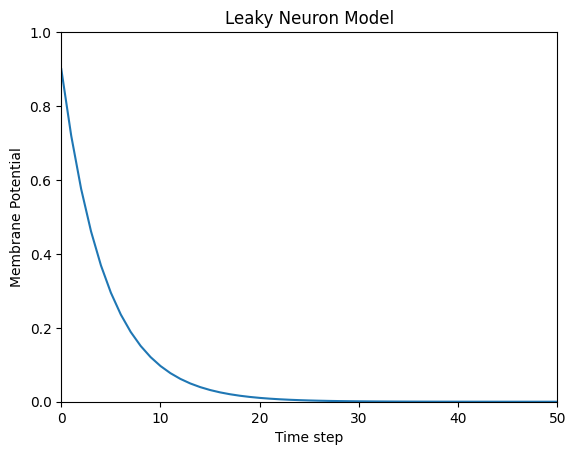

In [5]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")

이 지수 감쇠 곡선은 우리가 예상했던 것과 일치하는 것 같습니다!

# 3 Lapicque's LIF Neuron Model

신경막과 RC 회로의 유사성은 [Louis Lapicque in 1907](https://core.ac.uk/download/pdf/21172797.pdf)이 관찰했습니다. 그는 개구리의 신경 섬유를 짧은 전기 펄스로 자극했고, 뉴런 막이 누설을 갖는 커패시터로 근사될 수 있음을 발견했습니다. 우리는 snnTorch의 기본 LIF 뉴런 모델에 그의 이름을 붙여, 이러한 발견에 경의를 표합니다.

Lapicque의 모델에 담긴 개념 대부분은 다른 LIF 뉴런 모델로도 이어집니다. 이제 snnTorch를 사용해 이 뉴런을 시뮬레이션해 봅시다.


## 3.1 Lapicque: Without Stimulus

다음 코드 한 줄로 Lapicque 뉴런을 생성합니다.
이때 $R$과 $C$ 값은 계산을 단순하게 하기 위해 변경하지만, 이전 시정수 $\tau = 5\times 10^{-3}$ s는 그대로 유지합니다.


In [6]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

뉴런 모델은 이제 `lif1`에 저장되어 있습니다. 이 뉴런을 사용하려면:

**입력**

* `cur_in`: $I_{\rm in}$의 각 요소가 순차적으로 입력으로 전달됩니다(지금은 0).
* `mem`: 이전의 $U[t]$였던 막 전위로, 입력으로도 전달됩니다. 초기값은 임의로 $U[0] = 0.9~V$로 설정합니다.

**출력**

* `spk_out`: 다음 시점의 출력 스파이크 $S_{\rm out}[t+\Delta t]$ — 스파이크가 있으면 '1', 없으면 '0'
* `mem`: 다음 시점의 막 전위 $U_{\rm mem}[t+\Delta t]$

이 모든 값은 `torch.Tensor` 타입이어야 합니다.


In [7]:
# Initialize membrane, input, and output
mem = torch.ones(1) * 0.9  # U=0.9 at t=0
cur_in = torch.zeros(num_steps, 1)  # I=0 for all t
spk_out = torch.zeros(1)  # initialize output spikes

이 값들은 초기 시점 $t=0$에만 해당합니다.
`mem`이 시간에 따라 어떻게 변화하는지 분석하려면, 각 시점의 값을 기록할 리스트 `mem_rec`을 만들어야 합니다.


In [8]:
# A list to store recordings of membrane potential
mem_rec = [mem]

이제 시뮬레이션을 실행할 차례입니다! 각 시간 스텝마다 `mem`이 업데이트되어 `mem_rec`에 저장됩니다:


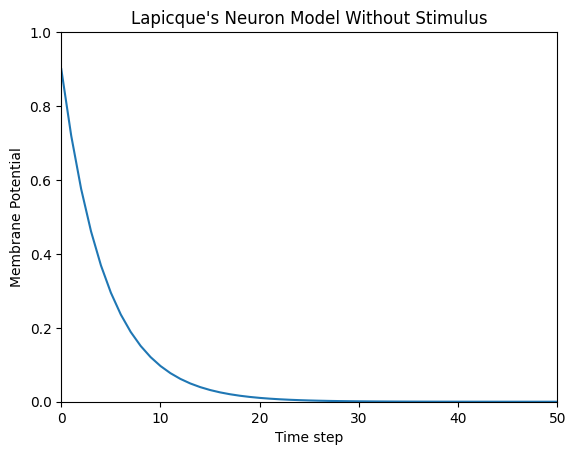

In [9]:
# pass updated value of mem and cur_in[step]=0 at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)

  # Store recordings of membrane potential
  mem_rec.append(mem)

# crunch the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")

입력 자극이 없는 경우, 막 전위는 시간이 지남에 따라 감소합니다.

## 3.2 Lapicque: Step Input

이제 $t = t_0$에서 켜지는 계단(step) 전류 $I_{\rm in}(t)$를 가해봅시다. 선형 1차 미분방정식은 다음과 같습니다:

$$
\tau \frac{dU_{\rm mem}}{dt} = -U_{\rm mem} + R I_{\rm in}(t)
$$

이 식의 일반해는 다음과 같습니다:

$$
U_{\rm mem} = I_{\rm in}(t)R + \big[ U_0 - I_{\rm in}(t)R \big] e^{-\frac{t}{\tau}}
$$

막 전위를 $U_{\rm mem}(t=0) = 0\ \text{V}$로 초기화하면:

$$
U_{\rm mem}(t) = I_{\rm in}(t) R \left[ 1 - e^{-\frac{t}{\tau}} \right]
$$

이 명시적인 시간 의존 형태를 보면, $U_{\rm mem}$이 $I_{\rm in}R$ 쪽으로 지수적으로 완화(relax)할 것으로 예상됩니다.
이를 시각화하기 위해, $t_0 = 10\ \text{ms}$에서 $I_{\rm in} = 100\ \text{mA}$의 전류 펄스를 발생시켜 보겠습니다.


In [10]:
# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.1), 0)  # input current turns on at t=10

# Initialize membrane, output and recordings
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes
mem_rec = [mem]

이번에는 `cur_in`의 새로운 값들이 뉴런에 전달됩니다.

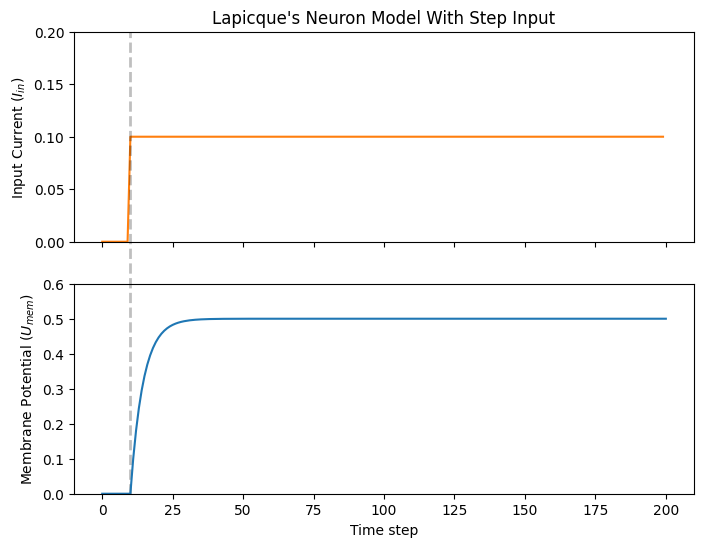

In [11]:
num_steps = 200

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)

# crunch -list- of tensors into one tensor
mem_rec = torch.stack(mem_rec)

plot_step_current_response(cur_in, mem_rec, 10)

$t \rightarrow \infty$일 때, 막 전위 $U_{\rm mem}$는 지수적으로 $I_{\rm in}R$로 수렴합니다.

In [12]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")

The calculated value of input pulse [A] x resistance [Ω] is: tensor([0.5000]) V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


거의 맞았습니다!

## 3.3 Lapicque: Pulse Input

이제 $t = 30\ \text{ms}$에서 계단 입력이 꺼진다면 어떻게 될까요?


In [13]:
# Initialize current pulse, membrane and outputs
cur_in1 = torch.cat((torch.zeros(10, 1), torch.ones(20, 1)*(0.1), torch.zeros(170, 1)), 0)  # input turns on at t=10, off at t=30
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]

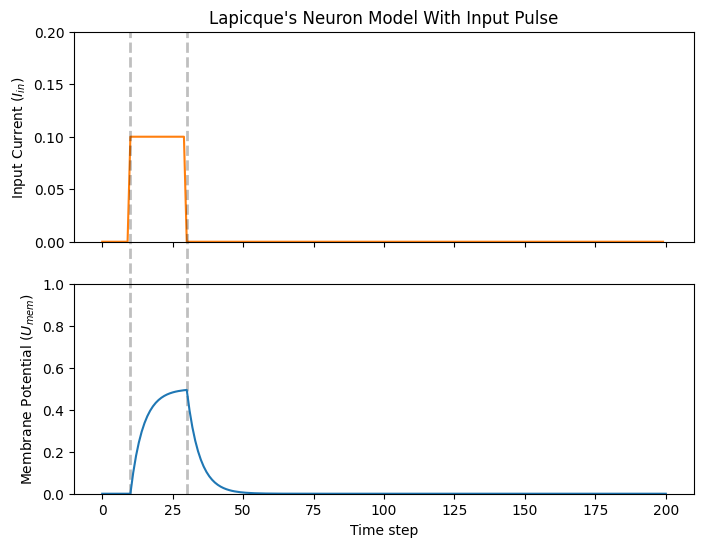

In [14]:
# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)
  mem_rec1.append(mem)
mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse",
                            vline1=10, vline2=30)

$U_{\rm mem}$은 계단 입력 때와 마찬가지로 상승하지만, 이제는 첫 번째 시뮬레이션에서처럼 시정수 $\tau$로 감소합니다.

회로에 전달되는 전하의 양 $Q = I \times t$를 절반의 시간 안에 거의 동일하게 전달해 보겠습니다. 이를 위해 입력 전류의 세기는 조금 높이고, 시간 구간은 줄여야 합니다.


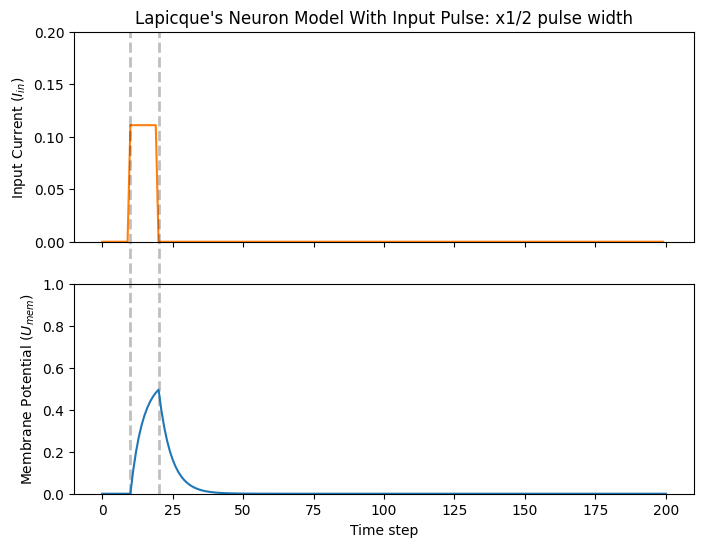

In [15]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10, 1), torch.ones(10, 1)*0.111, torch.zeros(180, 1)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)

이번에는 더 빠른 입력 펄스와 더 높은 세기로 다시 시도해 봅시다.


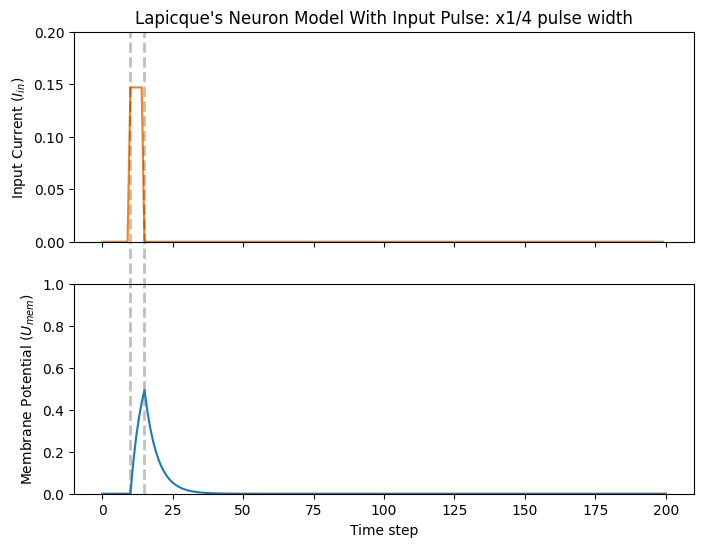

In [16]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10, 1), torch.ones(5, 1)*0.147, torch.zeros(185, 1)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)

이제 세 그래프를 비교해봅시다:

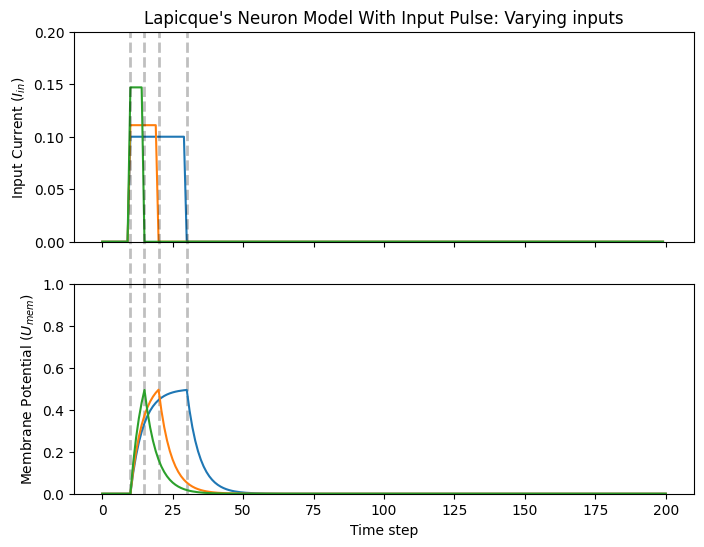

In [17]:
compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15,
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

입력 전류 펄스의 세기가 커질수록 막 전위의 상승 속도는 빨라집니다.
입력 전류 펄스 폭이 무한히 작아지는 극한, 즉 $T_W \rightarrow 0\ \text{s}$가 되면, 막 전위는 사실상 상승 시간이 없이 즉시 뛰어오르게 됩니다.


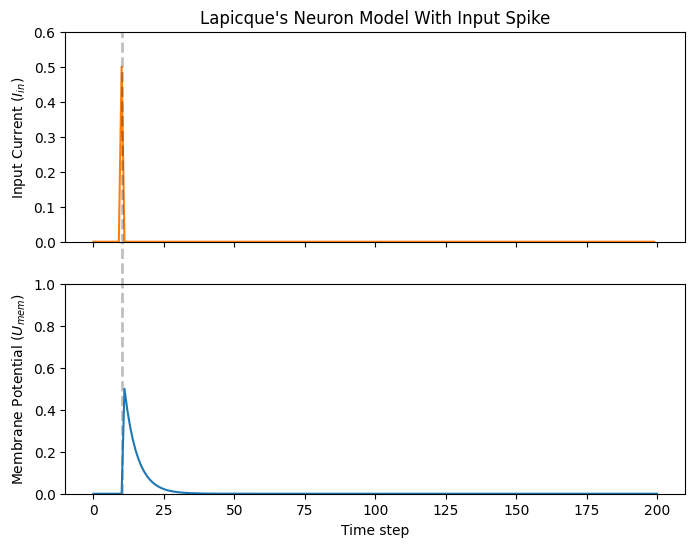

In [18]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10, 1), torch.ones(1, 1)*0.5, torch.zeros(189, 1)), 0)  # input only on for 1 time step
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)
  mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

plot_current_pulse_response(cur_in4, mem_rec4, "Lapicque's Neuron Model With Input Spike",
                            vline1=10, ylim_max1=0.6)

전류 펄스 폭이 이제 매우 짧아져, 사실상 하나의 스파이크처럼 보입니다.
즉, 전하는 무한히 짧은 시간에 전달되며, $t_0 \rightarrow 0$일 때

$$
I_{\rm in}(t) = \frac{Q}{t_0}
$$

가 됩니다. 이를 더 엄밀히 쓰면,

$$
I_{\rm in}(t) = Q\,\delta(t-t_0)
$$

여기서 $\delta(t-t_0)$는 디랙 델타(Dirac-Delta) 함수입니다.
물리적으로 전하를 ‘순간적으로’ 주입하는 것은 불가능하지만, $I_{\rm in}$을 적분하면 물리적으로 의미 있는 결과, 즉 전달된 전하량을 얻을 수 있습니다.

$$
1 = \int^{t_0 + a}_{t_0 - a} \delta(t-t_0)\, dt
$$

$$
f(t_0) = \int^{t_0 + a}_{t_0 - a} f(t)\, \delta(t-t_0)\, dt
$$

여기서 $f(t_0) = I_{\rm in}(t_0 = 10) = 0.5\,\text{A} \implies f(t) = Q = 0.5\,\text{C}$가 됩니다.


이제 막 전위가 휴지 상태에서 어떻게 누설(leak)되고, 입력 전류를 어떻게 적분(integrate)하는지 감이 잡히셨을 겁니다.
여기까지가 뉴런의 ‘leaky’와 ‘integrate’ 부분을 다룬 것이고, 이제 ‘fire’는 어떻게 될까요?


## 3.4 Lapicque: Firing

지금까지는 입력에 스파이크가 들어왔을 때 뉴런이 어떻게 반응하는지만 보았습니다. 뉴런이 자체적으로 출력 스파이크를 생성·방출하려면, 수동 막(passive membrane) 모델에 임계값(threshold)을 결합해야 합니다.

막 전위가 이 임계값을 초과하면, 수동 막 모델의 외부에서 전압 스파이크가 생성됩니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true' width="450">
</center>

이전에 만들었던 `leaky_integrate_neuron` 함수를 수정하여 스파이크 응답을 추가하세요.


In [19]:
# R=5.1, C=5e-3 for illustrative purposes
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = mem + (time_step/tau_mem)*(-mem + cur*R)
  return mem, spk

`threshold=1`로 설정하고, 계단(step) 전류를 가해 뉴런이 스파이크를 발생하도록 해보세요.


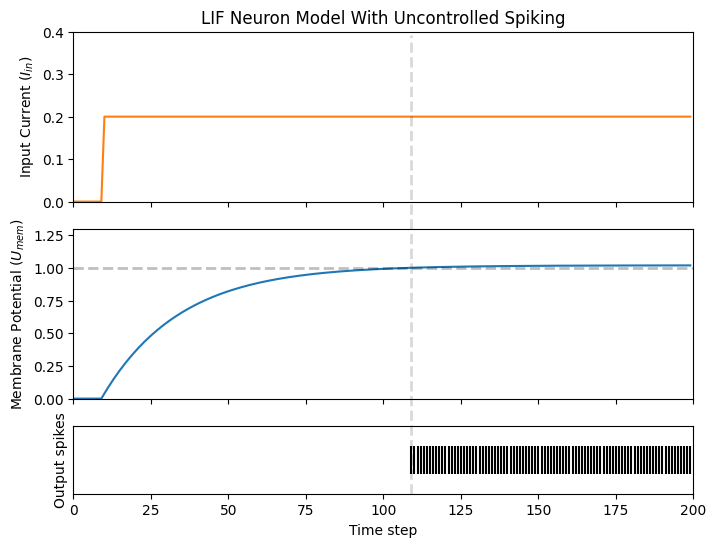

In [20]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Uncontrolled Spiking")

이런—출력 스파이크가 통제를 벗어났습니다! 이는 우리가 리셋 메커니즘을 추가하는 것을 잊었기 때문입니다. 실제로는 뉴런이 발화할 때마다 막 전위가 과분극되어 휴지 전위로 되돌아갑니다.

이 리셋 메커니즘을 우리 뉴런에 구현해 봅시다:


In [32]:
# LIF w/Reset mechanism
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

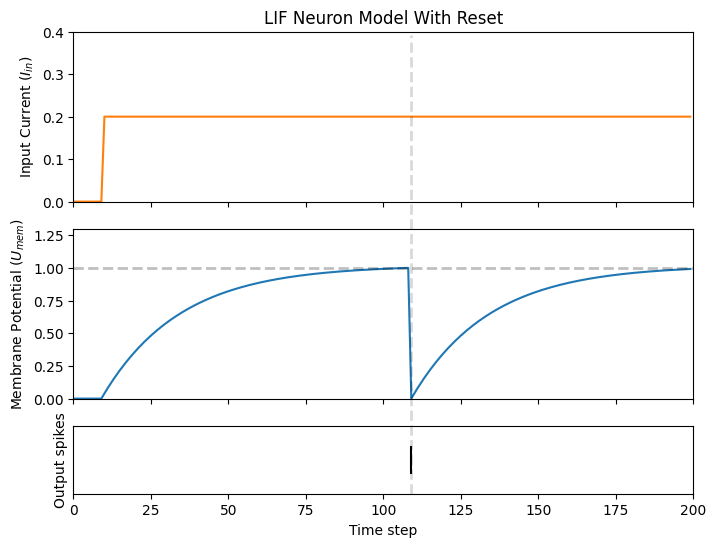

In [22]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Reset")

좋아요. 이제 동작하는 **leaky integrate-and-fire** 뉴런 모델이 완성되었습니다!

참고로, $I_{\rm in} = 0.2\ \text{A}$이고 $R < 5\ \Omega$이면, $I \times R < 1\ \text{V}$가 됩니다. 이때 `threshold=1`이라면 스파이킹이 발생하지 않습니다.
값을 바꿔가며 직접 테스트해 보셔도 좋습니다.


앞서와 마찬가지로, 위의 모든 코드는 snnTorch에서 제공하는 **Lapicque** 뉴런 모델을 호출하여 간단히 구현할 수 있습니다.


In [23]:
# Create the same neuron as before using snnTorch
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

print(f"Membrane potential time constant: {lif2.R * lif2.C:.3f}s")

Membrane potential time constant: 0.025s


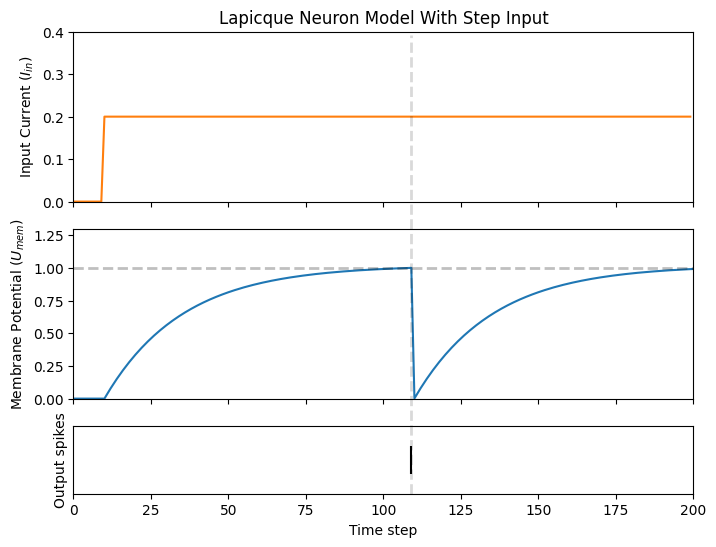

In [24]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.2), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 100 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Step Input")

막 전위가 지수적으로 상승하다가 임계값에 도달하면 리셋됩니다. 이 과정은 대략 $105\ \text{ms} < t_{\rm spk} < 115\ \text{ms}$ 구간에서 발생하는 것을 볼 수 있습니다.
호기심으로, 스파이크 기록이 실제로 어떤 값으로 구성되어 있는지 살펴봅시다.


In [25]:
print(spk_rec[105:115].view(-1))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


스파이크가 없는 경우는 $S_{\rm out} = 0$으로, 스파이크가 발생한 경우는 $S_{\rm out} = 1$로 표시됩니다.
여기서는 $S_{\rm out}[t = 109] = 1$에서 스파이크가 발생합니다.

각 항목이 텐서(tensor)로 저장되는 이유는, 앞으로의 튜토리얼에서 대규모 신경망을 시뮬레이션할 것이기 때문입니다. 각 항목에는 여러 뉴런의 스파이크 응답이 담기게 되며, 텐서는 GPU 메모리에 로드하여 학습 속도를 높일 수 있습니다.

$I_{\rm in}$이 증가하면, 막 전위가 임계값 $U_{\rm thr}$에 더 빨리 도달하게 됩니다.


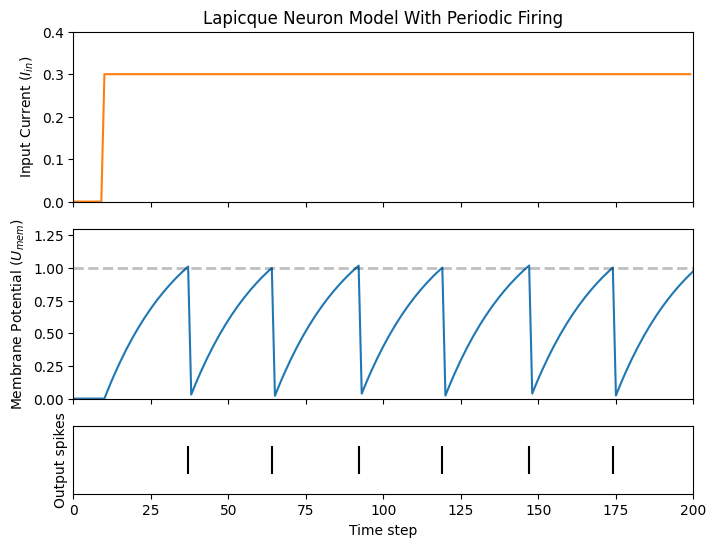

In [33]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Periodic Firing")

발화 빈도(firing frequency)의 비슷한 증가는 임계값(threshold)을 낮추는 것으로도 유도할 수 있습니다.
이를 위해서는 새로운 뉴런 모델을 초기화해야 하지만, 나머지 코드 블록은 위와 동일합니다.


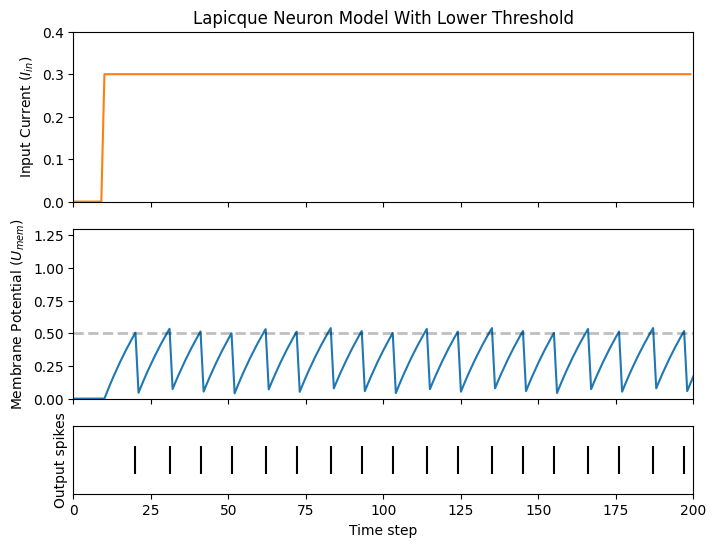

In [27]:
# neuron with halved threshold
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.3), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Lower Threshold")

그것이 일정한 전류를 주입했을 때 일어나는 일입니다.
하지만 심층 신경망과 생물학적 뇌 모두에서 대부분의 뉴런은 다른 뉴런들과 연결되어 있습니다.
따라서 일정한 전류 주입보다는 스파이크를 입력으로 받을 가능성이 더 높습니다.


## 3.5 Lapicque: Spike Inputs

[Tutorial 1](https://colab.research.google.com/github/jeshraghian/snntorch/blob/tutorials/examples/tutorial_1_spikegen.ipynb)에서 배운 내용을 활용해 봅시다.
`snntorch.spikegen` 모듈을 사용하여 무작위로 생성된 입력 스파이크를 만들어 보겠습니다.


In [28]:
# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps,1)) * 0.40)

코드를 실행시켜서 얼마나 많은 스파이크가 만들어졌는지 확인해봅시다.

There are 92 total spikes out of 200 time steps.


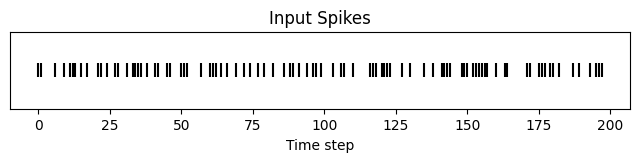

In [29]:
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

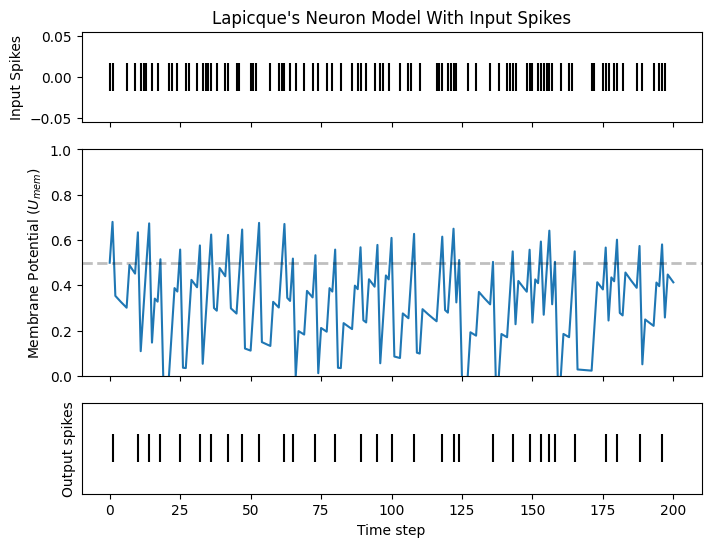

In [30]:
# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Lapicque's Neuron Model With Input Spikes")

## 3.6 Lapicque: Reset Mechanisms

우리는 이미 처음부터 리셋 메커니즘을 구현해 보았지만, 이번에는 조금 더 깊이 들어가 봅시다.
막 전위가 급격히 떨어지는 것은 스파이크 생성 빈도를 줄이는 데 도움을 주며, 이는 뇌가 매우 전력 효율적인 이유에 대한 이론의 일부를 뒷받침합니다.
생물학적으로 막 전위가 이렇게 떨어지는 현상을 **과분극(hyperpolarization)**이라고 부릅니다. 이 상태에서는 잠시 동안 뉴런에서 또 다른 스파이크를 유도하기가 더 어려워집니다. 여기서는 리셋 메커니즘을 이용해 과분극을 모델링합니다.

리셋 메커니즘은 다음 세 가지 방식으로 구현할 수 있습니다.

1. **감산 리셋(reset by subtraction)** *(기본값)* − 스파이크가 생성될 때마다 막 전위에서 임계값을 빼줍니다.
2. **제로 리셋(reset to zero)** − 스파이크가 생성될 때마다 막 전위를 0으로 강제로 설정합니다.
3. **리셋 없음(no reset)** − 아무 작업도 하지 않아, 발화가 잠재적으로 통제 불가능해질 수 있습니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true' width="450">
</center>  

리셋 메커니즘 간 전환을 시연하기 위해 다른 뉴런 모델을 생성해 봅시다.
기본적으로 snnTorch 뉴런 모델은 `reset_mechanism = "subtract"`를 사용합니다.
이 값을 명시적으로 변경하려면, `reset_mechanism = "zero"` 인자를 전달하면 됩니다.


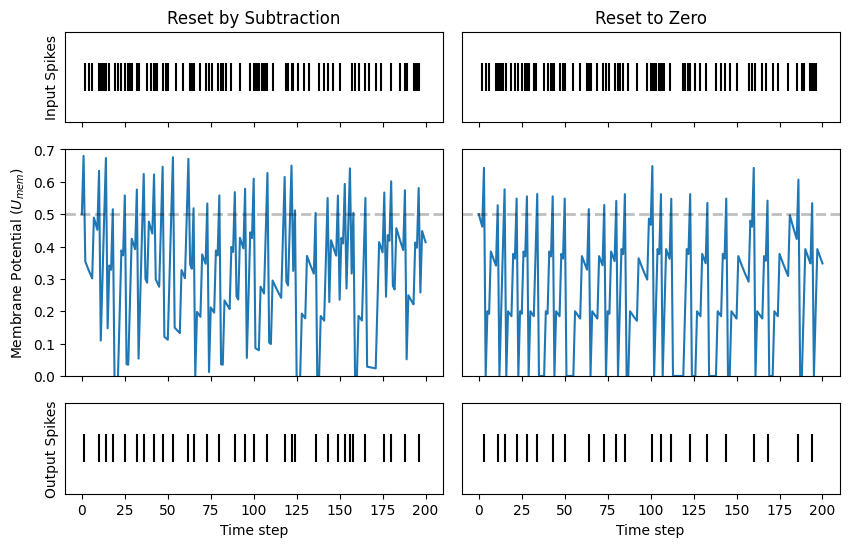

In [31]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps, 1)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)

막 전위의 변화를, 특히 임계값에 도달한 직후의 순간을 주의 깊게 보세요.
"Reset to Zero" 방식에서는 스파이크가 발생할 때마다 막 전위가 강제로 0으로 돌아가는 것을 확인할 수 있습니다.

그렇다면 어떤 방식이 더 좋을까요?
`reset_mechanism`에서 기본값인 `"subtract"`를 쓰면, 막 전위가 임계값을 얼마나 초과했는지를 버리지 않기 때문에 손실이 적습니다.

반면, `"zero"`로 강제 리셋을 하면 스파이크의 희소성이 높아지고, 전용 뉴로모픽 하드웨어에서 실행할 때 전력 소비를 줄일 가능성이 있습니다.
두 옵션 모두 직접 실험해 볼 수 있습니다.

이로써 LIF 뉴런 모델의 기본 개념을 모두 다루었습니다!


# Conclusion

실제로는 이 뉴런 모델을 신경망 학습에 바로 사용하지는 않을 것입니다.
Lapicque LIF 모델은 $R$, $C$, $\Delta t$, $U_{\rm thr}$, 그리고 리셋 메커니즘 선택 등 조정해야 할 하이퍼파라미터가 많아졌습니다. 이런 요소들이 모두 조금은 부담스럽죠.

그래서 [다음 튜토리얼](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서는 이러한 하이퍼파라미터 대부분을 제거하고, 대규모 딥러닝에 더 적합한 뉴런 모델을 소개할 예정입니다.

참고로, 관련 문서는 [여기](https://snntorch.readthedocs.io/en/latest/snntorch.html)에서 확인할 수 있습니다.

이 프로젝트가 마음에 든다면, GitHub 저장소에 ⭐를 눌러주시면 가장 쉽고 좋은 지원 방법이 됩니다.


## Further Reading
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [snnTorch documentation](https://snntorch.readthedocs.io/en/latest/snntorch.html) of the Lapicque, Leaky, Synaptic, and Alpha models
* [*Neuronal Dynamics:
From single neurons to networks and models of cognition*](https://neuronaldynamics.epfl.ch/index.html) by
Wulfram Gerstner, Werner M. Kistler, Richard Naud and Liam Paninski.
* [Theoretical Neuroscience: Computational and Mathematical Modeling of Neural Systems](https://mitpress.mit.edu/books/theoretical-neuroscience) by Laurence F. Abbott and Peter Dayan